# Clusterizacao - Case ImdbMovies

# IMDb TOP 250 Movies
![An image](https://static.amazon.jobs/teams/53/images/IMDb_Header_Page.jpg?1501027252)

**Este projeto consiste em treinar um sistema de recomendação de filmes utilizando as informações referentes aos top 250 filmes melhor avaliados pelo público na plataforma IMDb.**
*   A extração dos dados será feita por técnicas de web scraping (crawler).
*   O objetivo principal será agrupar os 250 filmes em "n" clusters classificados a partir das suas sinopses, aplicando técnicas de processamento de texto e algoritmos de clusterização.
*   Ao final, teremos um sistemas de recomendação baseado na similaridade das sinopses, e não apenas dos generos.

**Exemplo de aplicação prática: usuários receberão recomendações de filmes que estejam no mesmo cluster de sinopses de outros filmes que ele já tenha curtido.**

# Import das bibliotecas

In [58]:
# !pip install pycaret==3.0.2

In [1]:
import pandas as pd
import numpy as np
import requests
#from pprint import pprint
#from bs4 import BeautifulSoup
#import re
#import json
#from urllib.request import Request, urlopen
#from lxml import html
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from pycaret.clustering import *

## DataFrame

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

#EDA - Exploratory Data Analysis

In [3]:
# path_to_export = '/Users/henricobela/Desktop/Estudos/Github/Python/Faculdade/FIAP/Segundo_ano/2o_semestre/AUTOML/Clustering/atividade_clustering/raw_data' #mac
path_to_export = '/home/henrico/Github/Python/Faculdade/FIAP/Segundo_ano/2o_semestre/AUTOML/Clustering/atividade_clustering/raw_data' #linux
df = pd.read_csv(f'{path_to_export}/all_movies.csv', sep = ';')

df = df[["title_pt", "title_en", "year", "rating", "genre", "sinopse"]]

print(df.shape)
df.head()

(356, 6)


title_pt                              title_en  \
0                       Besouro Azul                       1. Besouro Azul   
1                             Barbie                             2. Barbie   
2                        Oppenheimer                        3. Oppenheimer   
3  As Tartarugas Ninja: Caos Mutante  4. As Tartarugas Ninja: Caos Mutante   
4                  Ruim Pra Cachorro                  5. Ruim Pra Cachorro   

   year      rating      genre  \
0  2023   6.8 (17K)       Ação   
1  2023  7.4 (255K)   Aventura   
2  2023  8.6 (381K)  Biografia   
3  2023   7.5 (19K)   Animação   
4  2023  6.4 (3.2K)   Animação   

                                             sinopse  
0  Jaime Reyes, um adolescente de origem mexicana...  
1  Viver na Terra da Barbie é ser um ser perfeito...  
2  A história do cientista americano J. Robert Op...  
3  Os irmãos Tartaruga trabalham para conquistar ...  
4  Um cachorro abandonado se une a outros vira-la...

In [4]:
# Adjusting variable types
df['year'] = df['year'].astype('int64')
df["rating"] = df["rating"].apply(lambda x: x.split("\xa0")[0] if not isinstance(x, float) else x)
idx = df[df.rating.isin(["Rate"])].index.tolist()
df.loc[idx, "rating"] = 6.0
df['rating'] = df['rating'].astype('float64')
df.rating.fillna(6.0, inplace = True)
df.dropna(inplace = True)
df

title_pt                              title_en  \
0                         Besouro Azul                       1. Besouro Azul   
1                               Barbie                             2. Barbie   
2                          Oppenheimer                        3. Oppenheimer   
3    As Tartarugas Ninja: Caos Mutante  4. As Tartarugas Ninja: Caos Mutante   
4                    Ruim Pra Cachorro                  5. Ruim Pra Cachorro   
..                                 ...                                   ...   
351                      Beau Tem Medo                         Beau Tem Medo   
352          Meus Sogros Tão pro Crime             Meus Sogros Tão pro Crime   
353                            Dunkirk                               Dunkirk   
354               Guardiões da Galáxia                  Guardiões da Galáxia   
355                            Titanic                               Titanic   

     year  rating      genre  \
0    2023     6.8       Ação   
1    2023     7.4   Aventura   
2    2023     8.6  Biografia   
3    2023     7.5   Animação   
4    2023     6.4   Animação   
..    ...     ...        ...   
351  2023     6.8    Comédia   
352  2023     5.4       Ação   
353  2017     7.8       Ação   
354  2014     8.0       Ação   
355  1997     7.9      Drama   

                                               sinopse  
0    Jaime Reyes, um adolescente de origem mexicana...  
1    Viver na Terra da Barbie é ser um ser perfeito...  
2    A história do cientista americano J. Robert Op...  
3    Os irmãos Tartaruga trabalham para conquistar ...  
4    Um cachorro abandonado se une a outros vira-la...  
..                                                 ...  
351  Após a morte repentina de sua mãe, um homem ge...  
352  Um conservador gerente de banco prestes a se c...  
353  Soldados aliados da Bélgica, do Império Britân...  
354  Um grupo de criminosos intergalácticos deve se...  
355  Uma aristocrata de dezessete anos se apaixona ...  

[354 rows x 6 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 0 to 355
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title_pt  354 non-null    object 
 1   title_en  354 non-null    object 
 2   year      354 non-null    int64  
 3   rating    354 non-null    float64
 4   genre     354 non-null    object 
 5   sinopse   354 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 19.4+ KB


In [6]:
df.describe()

year      rating
count   354.000000  354.000000
mean   1996.745763    7.805932
std      26.758765    0.963259
min    1921.000000    3.200000
25%    1980.000000    7.625000
50%    2004.000000    8.150000
75%    2022.000000    8.300000
max    2024.000000    9.300000

## Plots

In [7]:
df.genre.value_counts('d')

Ação                 0.245763
Drama                0.225989
Comédia              0.118644
Policial             0.110169
Animação             0.081921
Biografia            0.079096
Aventura             0.070621
Terror               0.042373
Mistério             0.011299
Faroeste             0.002825
Filme noir           0.002825
Fantasia             0.002825
Suspense             0.002825
Ficção científica    0.002825
Name: genre, dtype: float64

In [8]:
fig = px.bar(df.genre.value_counts('d')*100,
             text_auto=True,
             title = '% de Filmes por Gênero',
             labels={'index':'Gênero',
                     'value':'% de Filmes'})
fig.show()

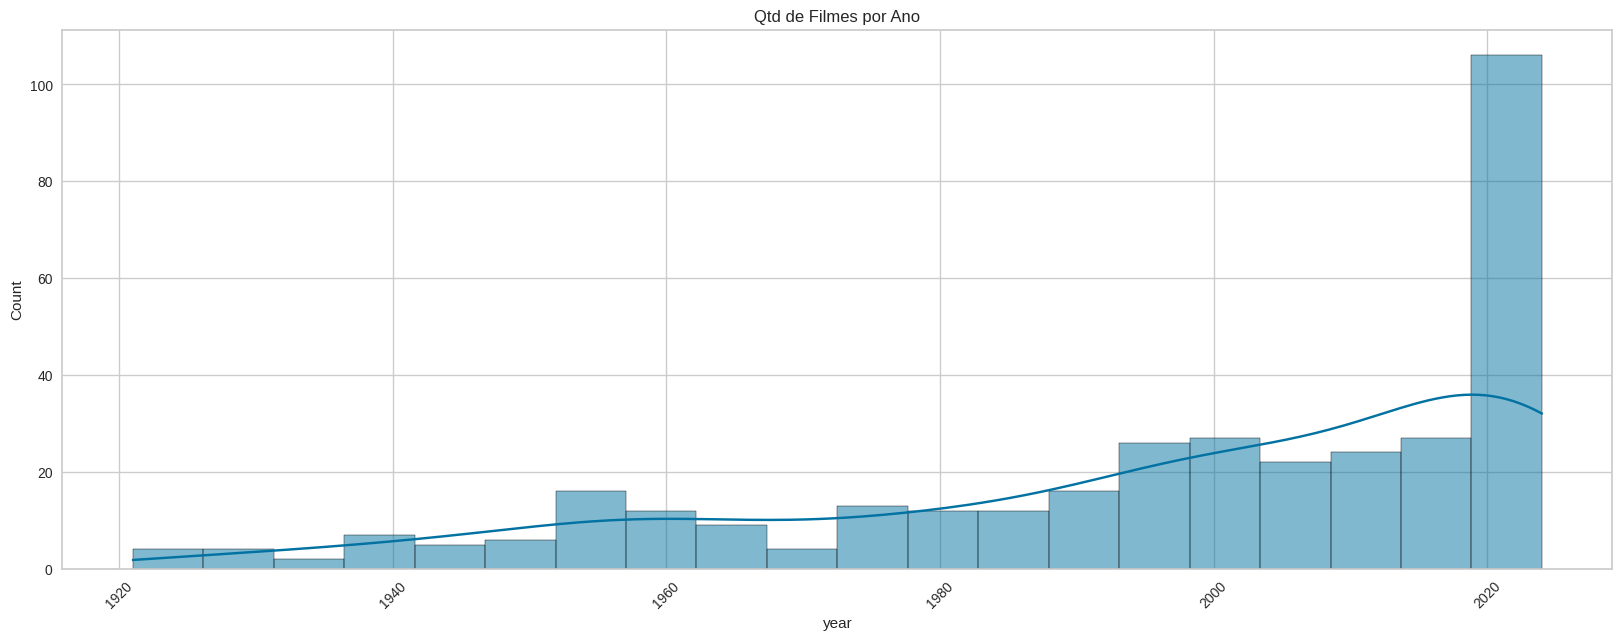

In [9]:
plt.figure(figsize = (20,7))
sns.histplot( df,
              x = 'year',
              kde = True, bins = 20).set_title('Qtd de Filmes por Ano')
plt.xticks(rotation=45)
plt.show()

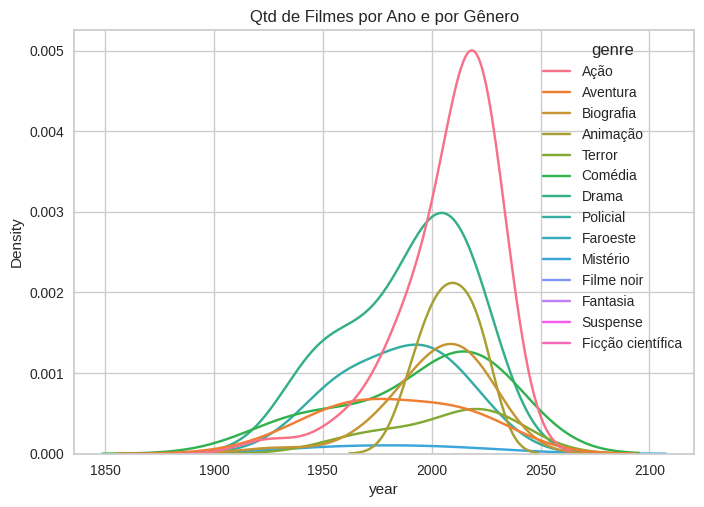

In [10]:
sns.kdeplot( df, x = 'year', hue = 'genre', bw_adjust = 1.5, warn_singular = False).set_title('Qtd de Filmes por Ano e por Gênero')
plt.show()

# Pré-processamento de texto

In [11]:
#convert sinopses to lowercase
df_processed = df.copy()
df_processed['sinopse'] = df_processed['sinopse'].str.lower()
df_processed['sinopse'].head()

0    jaime reyes, um adolescente de origem mexicana...
1    viver na terra da barbie é ser um ser perfeito...
2    a história do cientista americano j. robert op...
3    os irmãos tartaruga trabalham para conquistar ...
4    um cachorro abandonado se une a outros vira-la...
Name: sinopse, dtype: object

In [12]:
def qty_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [13]:
### Feature Engineering
df_processed['word_count'] = df_processed['sinopse'].apply(qty_words).astype('int64')
df_processed.head()

title_pt                              title_en  \
0                       Besouro Azul                       1. Besouro Azul   
1                             Barbie                             2. Barbie   
2                        Oppenheimer                        3. Oppenheimer   
3  As Tartarugas Ninja: Caos Mutante  4. As Tartarugas Ninja: Caos Mutante   
4                  Ruim Pra Cachorro                  5. Ruim Pra Cachorro   

   year  rating      genre                                            sinopse  \
0  2023     6.8       Ação  jaime reyes, um adolescente de origem mexicana...   
1  2023     7.4   Aventura  viver na terra da barbie é ser um ser perfeito...   
2  2023     8.6  Biografia  a história do cientista americano j. robert op...   
3  2023     7.5   Animação  os irmãos tartaruga trabalham para conquistar ...   
4  2023     6.4   Animação  um cachorro abandonado se une a outros vira-la...   

   word_count  
0          24  
1          29  
2          17  
3          19  
4          15

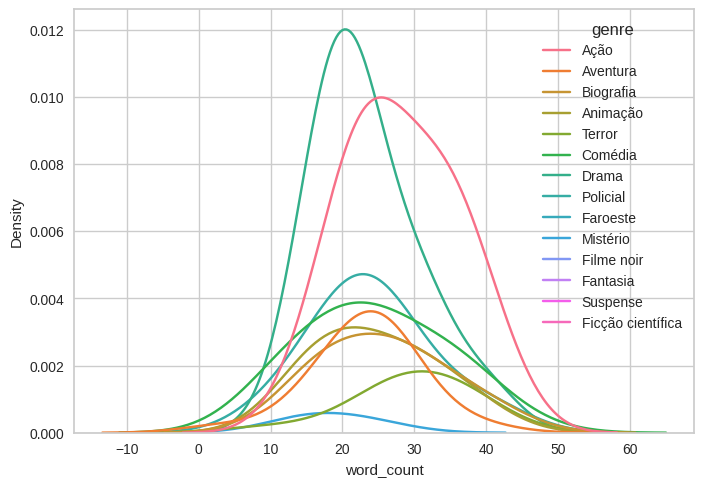

In [14]:
sns.kdeplot( df_processed, x = 'word_count', hue = 'genre', bw_adjust = 1.5, warn_singular = False)
plt.show()

## Nuvem de palavras

### Antes de remover as stopwords

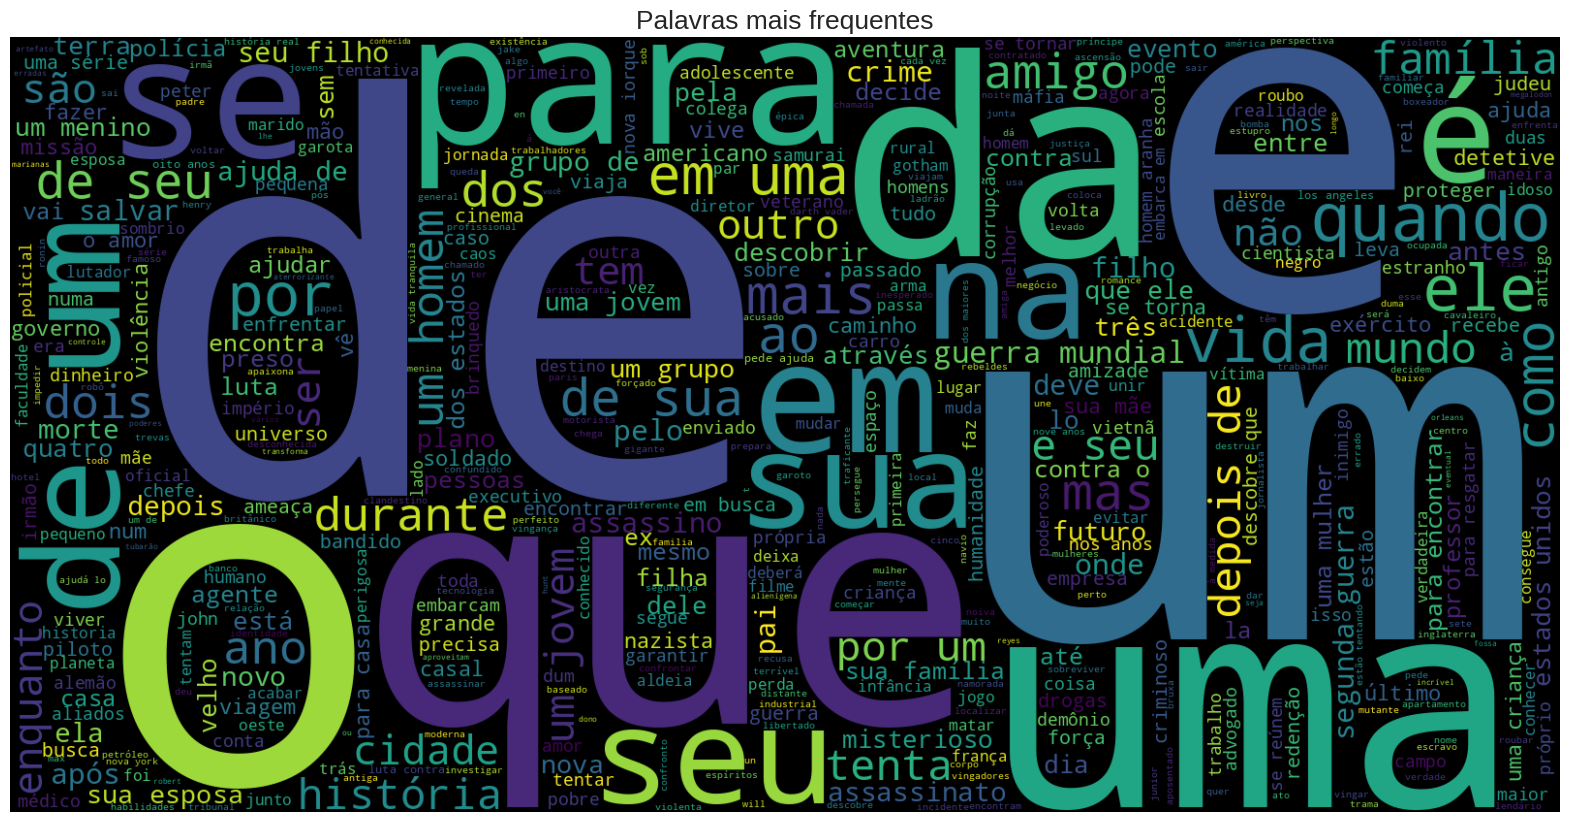

In [15]:
text = ' '.join([phrase for phrase in df_processed['sinopse']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes', fontsize = 19)
plt.show()

### Após remoção das stopwords

In [16]:
import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('portuguese')
print(stopwords)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/henrico/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


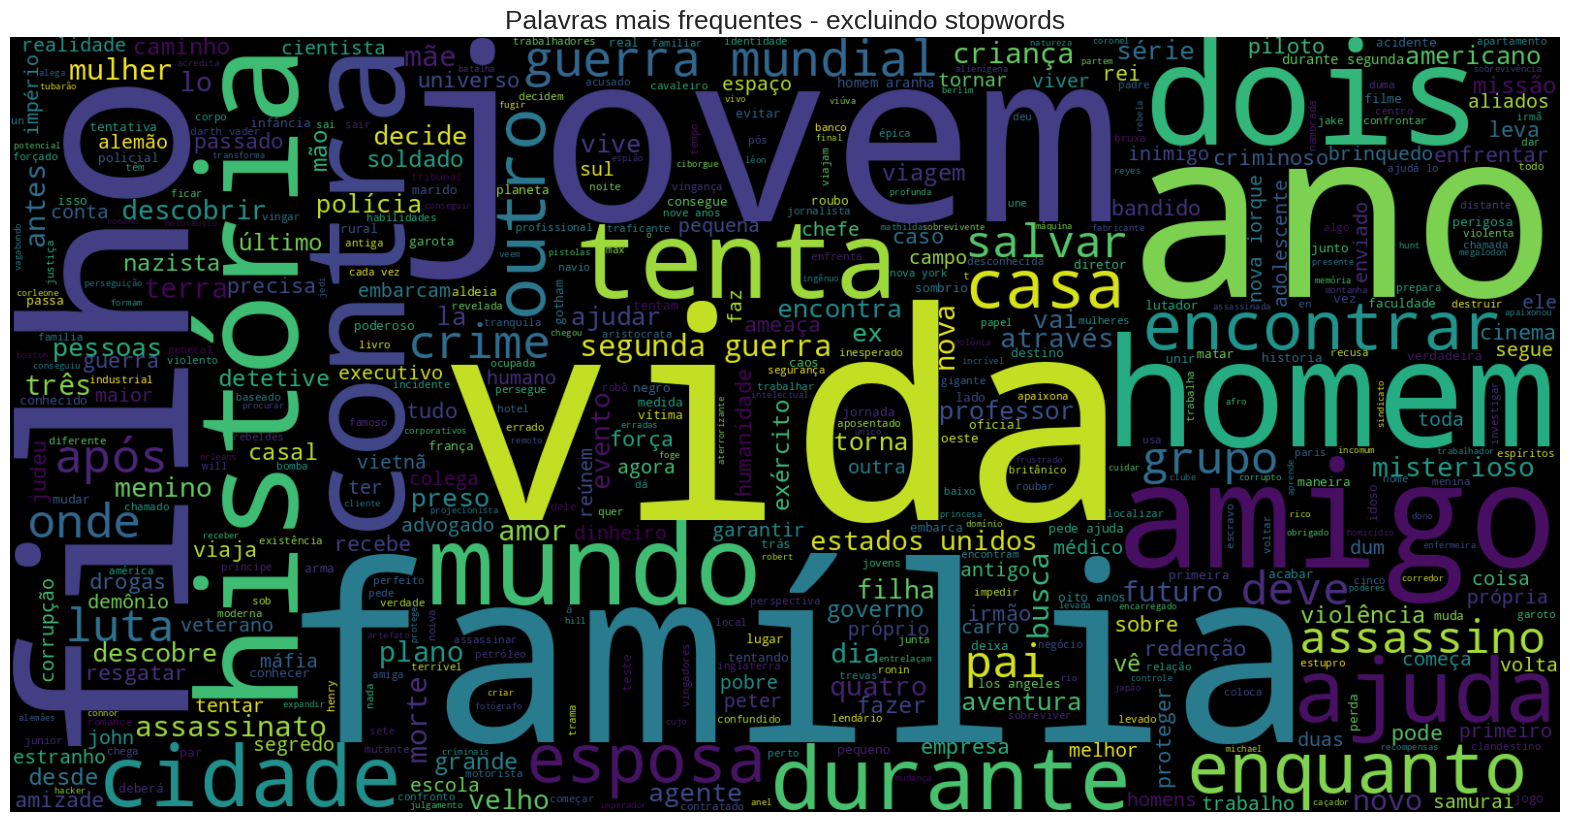

In [17]:
df_processed['sinopse_no_stopwords'] = df_processed['sinopse'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
text = ' '.join([phrase for phrase in df_processed['sinopse_no_stopwords']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes - excluindo stopwords', fontsize = 19)
plt.show()

## Aplicando TF-IDF
Term Frequency-Inverse Document Frequency

O TF-IDF define a importância de um termo levando em consideração a importância desse termo em um único documento e dimensionando-o por sua importância em todos os documentos.

In [18]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df_processed['sinopse_no_stopwords'])

In [19]:
print(X.shape)
X.toarray()

(354, 153)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.75045653, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# AutoML | PyCaret - Clustering

## Setup

In [20]:
s = setup(data = X.toarray(),
          session_id = 123)

# Create Model

In [21]:
mdl_kmeans = create_model('kmeans')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [22]:
mdl_dbscan = create_model('dbscan')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
mdl_meanshift = create_model('meanshift')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

# Assign Model

In [24]:
df_kmeans = assign_model(mdl_kmeans)
display(df_kmeans.Cluster.value_counts())
df_kmeans

Cluster 0    251
Cluster 1     36
Cluster 3     35
Cluster 2     32
Name: Cluster, dtype: int64

feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0          0.0        0.0        0.0        0.0   0.000000   0.000000   
1          0.0        0.0        0.0        0.0   0.000000   0.000000   
2          0.0        0.0        0.0        0.0   0.000000   0.000000   
3          0.0        0.0        0.0        0.0   0.000000   0.000000   
4          0.0        0.0        0.0        0.0   0.000000   0.000000   
..         ...        ...        ...        ...        ...        ...   
349        0.0        0.0        0.0        0.0   0.000000   0.000000   
350        0.0        0.0        0.0        0.0   0.000000   0.000000   
351        0.0        0.0        0.0        0.0   0.401682   0.401682   
352        0.0        0.0        0.0        0.0   0.000000   0.000000   
353        0.0        0.0        0.0        0.0   0.000000   0.000000   

     feature_7  feature_8  feature_9  feature_10  ...  feature_145  \
0          0.0   0.000000        0.0         0.0  ...          0.0   
1          0.0   0.000000        0.0         0.0  ...          0.0   
2          0.0   0.777718        0.0         0.0  ...          0.0   
3          0.0   0.000000        0.0         0.0  ...          0.0   
4          0.0   0.000000        0.0         0.0  ...          0.0   
..         ...        ...        ...         ...  ...          ...   
349        0.0   0.000000        0.0         0.0  ...          0.0   
350        0.0   0.000000        0.0         0.0  ...          0.0   
351        0.0   0.000000        0.0         0.0  ...          0.0   
352        0.0   0.000000        0.0         0.0  ...          0.0   
353        0.0   0.000000        0.0         0.0  ...          0.0   

     feature_146  feature_147  feature_148  feature_149  feature_150  \
0       0.000000          0.0          0.0          0.0          0.0   
1       0.000000          0.0          0.0          0.0          0.0   
2       0.000000          0.0          0.0          0.0          0.0   
3       0.000000          0.0          0.0          0.0          0.0   
4       0.000000          0.0          0.0          0.0          0.0   
..           ...          ...          ...          ...          ...   
349     0.000000          0.0          0.0          0.0          0.0   
350     0.507914          0.0          0.0          0.0          0.0   
351     0.000000          0.0          0.0          0.0          0.0   
352     0.000000          0.0          0.0          0.0          0.0   
353     0.000000          0.0          0.0          0.0          0.0   

     feature_151  feature_152  feature_153    Cluster  
0       0.000000     0.000000          0.0  Cluster 0  
1       0.750457     0.000000          0.0  Cluster 0  
2       0.000000     0.000000          0.0  Cluster 0  
3       0.000000     0.000000          0.0  Cluster 0  
4       0.000000     0.000000          0.0  Cluster 0  
..           ...          ...          ...        ...  
349     0.000000     0.451828          0.0  Cluster 0  
350     0.000000     0.000000          0.0  Cluster 2  
351     0.000000     0.000000          0.0  Cluster 3  
352     0.000000     0.000000          0.0  Cluster 0  
353     0.000000     0.000000          0.0  Cluster 0  

[354 rows x 154 columns]

In [25]:
df_db = assign_model(mdl_dbscan)
df_db.Cluster.value_counts()

Cluster -1    344
Cluster 0      10
Name: Cluster, dtype: int64

In [26]:
df_meanshift = assign_model(mdl_meanshift)
df_meanshift.Cluster.value_counts()

Cluster 0    354
Name: Cluster, dtype: int64

# Analyze Models

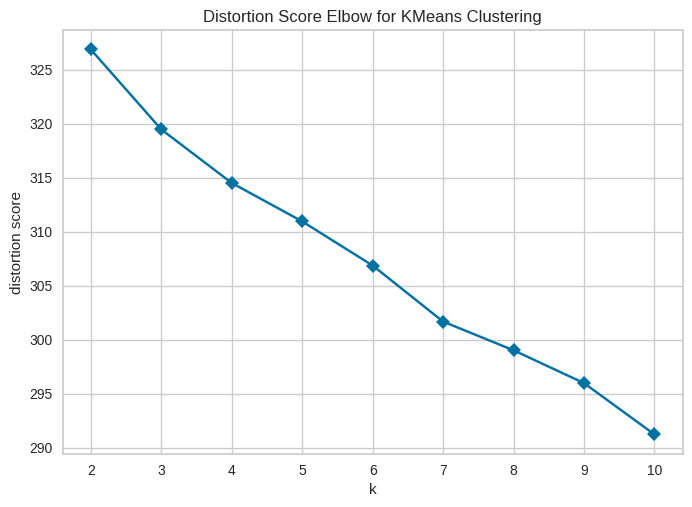

In [27]:
plot_model(mdl_kmeans, plot = 'elbow')

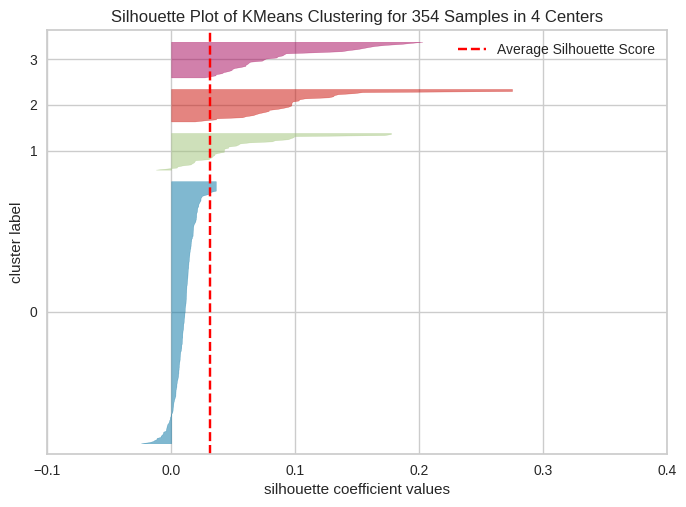

In [28]:
plot_model(mdl_kmeans, plot = 'silhouette')

In [29]:
plot_model(mdl_kmeans, plot = 'distribution')

In [30]:
plot_model(mdl_kmeans, plot = 'cluster')

In [31]:
plot_model(mdl_kmeans, plot = 'tsne')

In [32]:
evaluate_model(mdl_kmeans)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Filmes por cluster

In [33]:
df_processed['cluster'] = df_kmeans['Cluster']
df_processed

title_pt                              title_en  \
0                         Besouro Azul                       1. Besouro Azul   
1                               Barbie                             2. Barbie   
2                          Oppenheimer                        3. Oppenheimer   
3    As Tartarugas Ninja: Caos Mutante  4. As Tartarugas Ninja: Caos Mutante   
4                    Ruim Pra Cachorro                  5. Ruim Pra Cachorro   
..                                 ...                                   ...   
351                      Beau Tem Medo                         Beau Tem Medo   
352          Meus Sogros Tão pro Crime             Meus Sogros Tão pro Crime   
353                            Dunkirk                               Dunkirk   
354               Guardiões da Galáxia                  Guardiões da Galáxia   
355                            Titanic                               Titanic   

     year  rating      genre  \
0    2023     6.8       Ação   
1    2023     7.4   Aventura   
2    2023     8.6  Biografia   
3    2023     7.5   Animação   
4    2023     6.4   Animação   
..    ...     ...        ...   
351  2023     6.8    Comédia   
352  2023     5.4       Ação   
353  2017     7.8       Ação   
354  2014     8.0       Ação   
355  1997     7.9      Drama   

                                               sinopse  word_count  \
0    jaime reyes, um adolescente de origem mexicana...          24   
1    viver na terra da barbie é ser um ser perfeito...          29   
2    a história do cientista americano j. robert op...          17   
3    os irmãos tartaruga trabalham para conquistar ...          19   
4    um cachorro abandonado se une a outros vira-la...          15   
..                                                 ...         ...   
351  após a morte repentina de sua mãe, um homem ge...          32   
352  um conservador gerente de banco prestes a se c...          33   
353  soldados aliados da bélgica, do império britân...          25   
354  um grupo de criminosos intergalácticos deve se...          20   
355  uma aristocrata de dezessete anos se apaixona ...          20   

                                  sinopse_no_stopwords    cluster  
0    jaime reyes, adolescente origem mexicana encon...  Cluster 0  
1    viver terra barbie perfeito lugar perfeito. me...  Cluster 0  
2    história cientista americano j. robert oppenhe...  Cluster 0  
3    irmãos tartaruga trabalham conquistar amor cid...  Cluster 0  
4    cachorro abandonado une outros vira-latas ving...  Cluster 0  
..                                                 ...        ...  
351  após morte repentina mãe, homem gentil atormen...  Cluster 3  
352  conservador gerente banco prestes casar amor v...  Cluster 0  
353  soldados aliados bélgica, império britânico fr...  Cluster 0  
354  grupo criminosos intergalácticos deve unir imp...        NaN  
355  aristocrata dezessete anos apaixona artista ge...        NaN  

[354 rows x 9 columns]

## % de Gêneros por Cluster

In [34]:
fig = px.bar(df_processed.cluster.value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

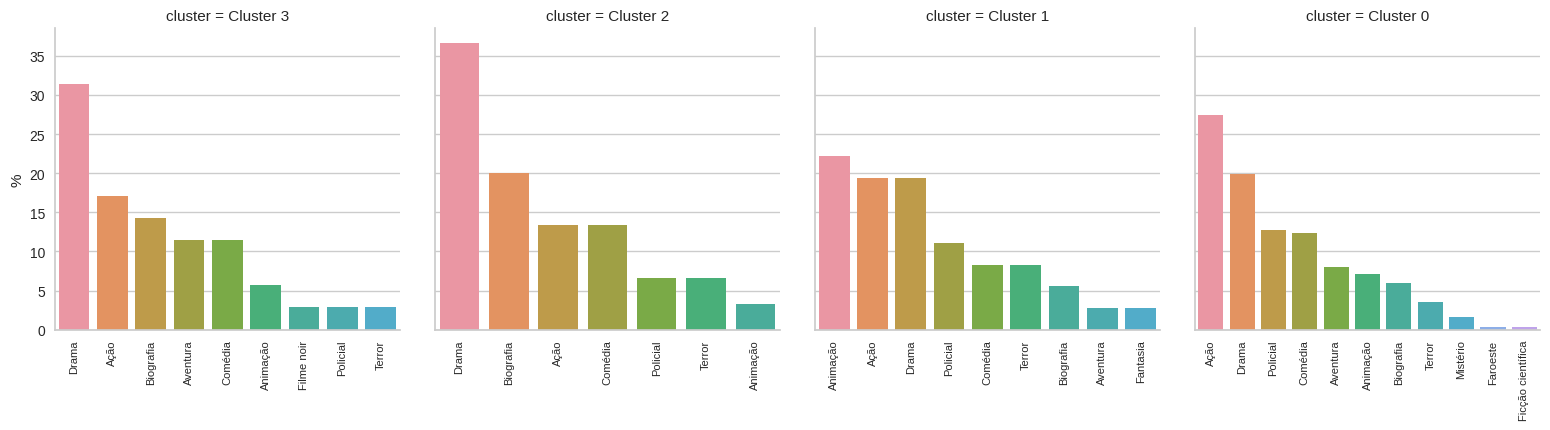

In [35]:
df_plot = df_processed.groupby(['cluster', 'genre'])['title_pt'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title_pt':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

## Ano de Lançamento por Cluster

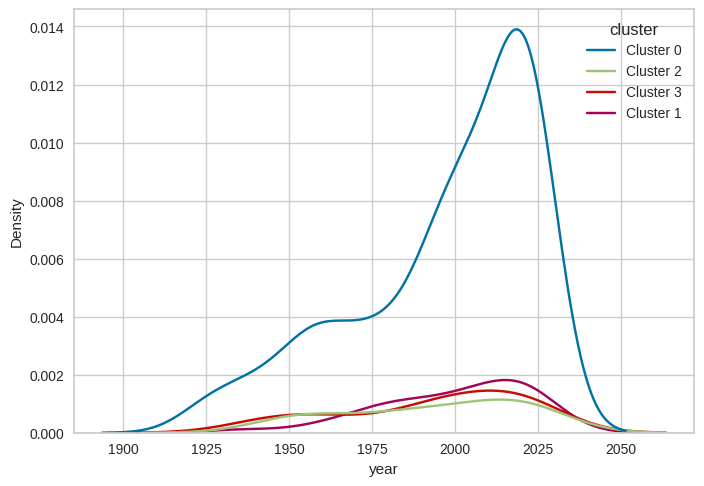

In [36]:
sns.kdeplot(df_processed, x = 'year', hue = 'cluster');

## Radar | Gêneros por Cluster

In [37]:
df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'cluster', columns = 'genre', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

cluster              genre  Cluster 0  Cluster 1  Cluster 2  Cluster 3
0                 Animação   7.171315  22.222222   3.333333   5.714286
1                 Aventura   7.968127   2.777778   0.000000  11.428571
2                     Ação  27.490040  19.444444  13.333333  17.142857
3                Biografia   5.976096   5.555556  20.000000  14.285714
4                  Comédia  12.350598   8.333333  13.333333  11.428571
5                    Drama  19.920319  19.444444  36.666667  31.428571
6                 Fantasia   0.000000   2.777778   0.000000   0.000000
7                 Faroeste   0.398406   0.000000   0.000000   0.000000
8        Ficção científica   0.398406   0.000000   0.000000   0.000000
9               Filme noir   0.000000   0.000000   0.000000   2.857143
10                Mistério   1.593625   0.000000   0.000000   0.000000
11                Policial  12.749004  11.111111   6.666667   2.857143
12                  Terror   3.585657   8.333333   6.666667   2.857143

In [38]:
df_polar = df_pivot.melt(id_vars=['genre'])
df_polar.head()

genre    cluster      value
0   Animação  Cluster 0   7.171315
1   Aventura  Cluster 0   7.968127
2       Ação  Cluster 0  27.490040
3  Biografia  Cluster 0   5.976096
4    Comédia  Cluster 0  12.350598

In [39]:
fig = px.line_polar(df_polar, r='value', theta='genre', color = 'cluster', line_close=True)
fig.show();

# Nuvem de Palavras por Cluster

# Considerações Finais
* **Exercício: Reescrever as análises / conclusões devido a atualização da base**

Cluster 0


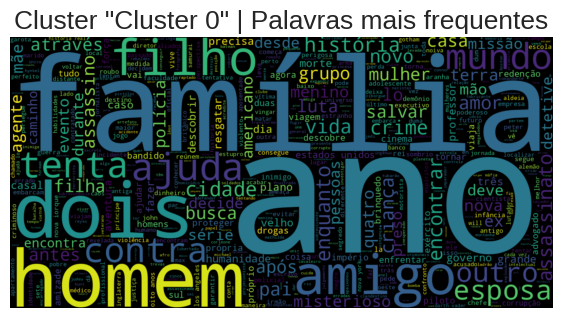

Cluster 2


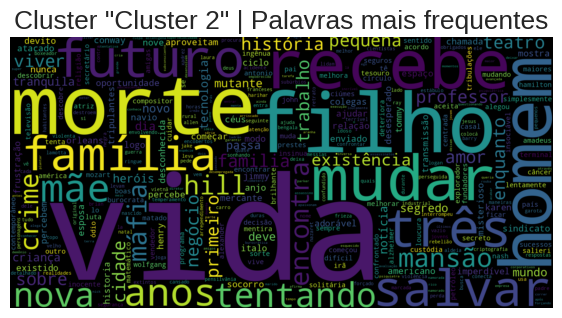

Cluster 3


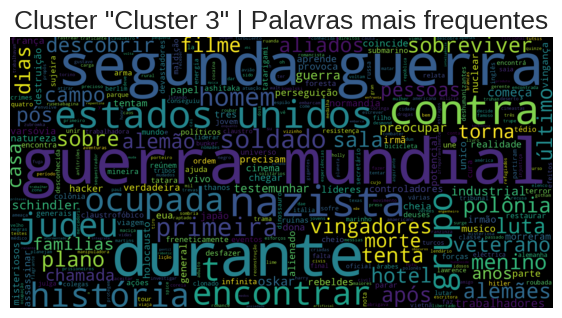

Cluster 1


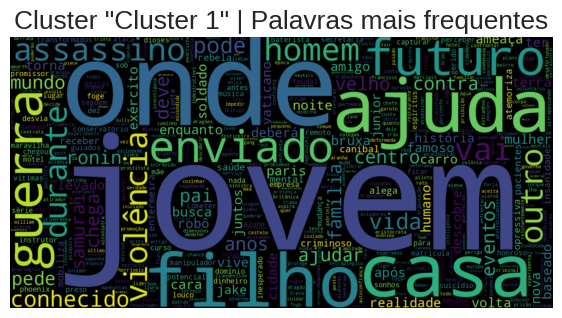

nan


In [44]:
def word_cloud_cluster(cluster:int):
  text = ' '.join([phrase for phrase in df_processed.loc[df_processed.cluster == cluster]['sinopse_no_stopwords']])
  plt.figure(figsize=(7,5), facecolor='None')
  wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Cluster "{cluster}" | Palavras mais frequentes', fontsize = 19)
  plt.show()
  return

list_clusters = df_processed.cluster.unique().tolist()
for c in list_clusters:
  print(c)
  if str(c) != "nan":
    word_cloud_cluster(c)

#Conclusões

** Na seção "Comparativo entre os 10 clusters" foram apresentadas diferentes formas de caracterizar cada cluster.**

1. Primeiro foi demonstrado que o cluster #2 foi o que apresentou o maior número de amostras (filmes). _(Idealmente os cluster devem conter quantidades balanceadas, porém neste projeto, por ter um dataset com baixo número de amostras (250), não foi possível atender esta premissa)_.

2. Depois foi analisado o % de cada gênero por cluster, sendo os dois gêneros mais representativos do:

  2.1 Cluster 0: Ação, Biografia, Drama, Animação, Mistério, Policial, Terror. Com a maior parte em Ação.

  2.2 Cluster 1: Drama, Animação, Ação, Policial, Biografia. Maior fatia em Drama.  

  2.3 Cluster 2: Drama, Ação, Biografia. Enfase em Drama para este cluster.

  2.4 Cluster 3: Drama, Ação, Biografia, Comédia, Animação, Policial, Terror. Drama prevaleceu.

  2.5 Cluster 4: Policial, Ação, Comédia, Drama, Biografia, Misterio, Terror. Para os tres primeiros um quase empate, assim como os 3 ultimos. 

  2.6 Cluster 5: Ação, Drama, Policial, Comedia, Animacao, Aventura, Terror, Biografia, Fantasia, Faroeste, Ficcao Cientifica. Neste cluster, apesar da variedade de generos, Acao pode ter uma melhor relevancia.

  2.7 Cluster 6: Drama, Aventura, Ação, Animacao, Comédia, Terror, Biografia, Policial. Drama novamente com a maior parte!

  2.8 Cluster 7: Drama, Comedia, Biografia, Policial, Misterio, Animacao, Aventura, Acao. Drama com a maior parte, porem houve uma linearidade entre os demais.

  2.9 Cluster 8: Acao, Comedia, Drama, Animacao, Aventura, Biografia, Policial, Suspense, Terror. Acao com a maior parte, porem houve uma linearidade entre os demais.

  2.9.1 Cluster 9: Quase empate entre os generos Acao, Drama, Aventura, Biografia, Comedia, Animacao.


3. Na sequência foi avaliado a distribuição dos anos de lançamento dos filmes por cluster, sem diferença siginificativa entre eles, com maior concentração ao redor do ano 2000. Apesar de apresentar uma densidade exacerbada para o cluster 6. É possivel que o resultado enorme obtido seja por conta da base de dados desbalanceada, e ou por poucas amostras. 

4. O grafico de radar apresentado, pode ser analisado com os seguintes pontos:

  4.1 Mistério, Suspense, Faroeste, Ficcao Cientifica, e Fantasia quase nao tiveram relevancia para os clusters.
  
  4.2 Terror e Comédia apesar de estarem entre os maiores relevantes, nao apresentaram relevancia na separaçao dos clusters.

  4.3 Os clusters 0 e 2 apresentam muita relevancia para os generos de Drama e Ação, respectivamente.


5. E finalmente, foram apresentadas as nuvens de palavras por cluster, onde em linhas gerais destacam-se:

  5.1 o Cluster 0 -> Senhor dos Aneis (É possivel identificar que o cluster 0 obteve uma alta taxa de acerto para o genero que mais aparece neste cluster: Açao)

  5.2 o Cluster 1 -> Casa, Anos, Presos. (Acertos para com seu genero principal: Drama)

  5.3 o Cluster 2 -> Esposa, Mulher, Escritor, Berlim. (Acertos para com seu genero principal: Drama)

  5.4 o Cluster 3 -> Filho, Vida, Amor, Encontro. (Acertos para com seu genero principal: Drama)

  5.5 o Cluster 4 -> Filho, Assassinato, Familia, Mae (Este Cluster teve uma alta taxa de acerto para com seu genero, Policial)

  5.6 o Cluster 5 -> Jovem, Cidade, Familia, Historia, Restagar. (Acertos para com seu genero principal: Ação)

  5.7 o Cluster 6 -> Amigo, Menino, Viagem. (Acertos para com seu genero principal: Drama)

  5.8 o Cluster 7 -> Homem, Crime, Estados Unidos, Corrupcao. (Embora este Cluster apresentou poucos acertos para com seu genero: Drama, é possivel que com uma nova leva de dados, possa melhorar)

  5.9 o Cluster 8 -> Piloto, Terra, Morte, Galaxia, Mitchell (Acertos para com seu genero principal: Ação)

  5.9.1 o Cluster 9 -> Guerra mundial, Segunda guerra, Polonia, Nazismo, Sobreviver, Alemaes (Acertos para com seu genero principal: Ação)



** Em resumo neste projeto foram aplicados conceitos de:

1. Webscraping / Crawler para coleta de dados do site IMDb
2. Pré-processamento de texto com utilização de técnicas de NLP, limpeza do texto, lemmatização, remoção de stopwords, remoção de pontuação, remoção de acentuação.
3. Tecnicas e abordagens diferentes para definir o numero adequado de clusters, que, a partir desses resultados, foi denifido que o numero de clusters mais adequado é o de 10 clusters, e conforme acima, foi possivel obter bons resultados, metodos:
  3.1 Metodo Elbow
  3.2 Metodo Silhouette
  3.3 Metodo Davies Bouldin Score
  3.4 Metodo Calinski Harabasz Score
4. Clusterização


Desta forma consideramos que o objetivo inicial foi atingido sendo possível a clusterização dos filmes baseado na sinopse / descrição de cada um, gerando desta forma a possibilidade de recomendar filmes aos usuários não apenas pela classificação tradicional por gêneros, mas também pelos clusters identificados neste projeto.

Os posters dos filmes foram extraidos do site tambem, para que assim, futuramente possamos realizar uma melhor analise com base nas imagens, e tambem, dar um melhor retorno ao solicitante, ao recomendar um filme!
A extraçao dessas imagens de posters foi feita atravez de webscrapping e arrays numpy, onde baixamos a imagem em ioBytes e a convertemos em escala de cinza, posteriormente em array numpy.

**Em termos práticos, se um usuário avalia positivamente um filme, os filmes pertecentes ao mesmo cluster podem ser recomendados a ele.**


# Adicionando demais features do df all_movies ao X

In [45]:
pd.DataFrame(X.toarray()).shape

(354, 153)

In [46]:
df_processed.shape

(354, 9)

In [47]:
df_all = pd.concat([
                    df_processed.drop('cluster', axis = 1),
                    pd.DataFrame(X.toarray())
                   ]
                   , axis = 1
                   )
df_all

title_pt                              title_en  \
0                         Besouro Azul                       1. Besouro Azul   
1                               Barbie                             2. Barbie   
2                          Oppenheimer                        3. Oppenheimer   
3    As Tartarugas Ninja: Caos Mutante  4. As Tartarugas Ninja: Caos Mutante   
4                    Ruim Pra Cachorro                  5. Ruim Pra Cachorro   
..                                 ...                                   ...   
353                            Dunkirk                               Dunkirk   
354               Guardiões da Galáxia                  Guardiões da Galáxia   
355                            Titanic                               Titanic   
275                                NaN                                   NaN   
290                                NaN                                   NaN   

       year  rating      genre  \
0    2023.0     6.8       Ação   
1    2023.0     7.4   Aventura   
2    2023.0     8.6  Biografia   
3    2023.0     7.5   Animação   
4    2023.0     6.4   Animação   
..      ...     ...        ...   
353  2017.0     7.8       Ação   
354  2014.0     8.0       Ação   
355  1997.0     7.9      Drama   
275     NaN     NaN        NaN   
290     NaN     NaN        NaN   

                                               sinopse  word_count  \
0    jaime reyes, um adolescente de origem mexicana...        24.0   
1    viver na terra da barbie é ser um ser perfeito...        29.0   
2    a história do cientista americano j. robert op...        17.0   
3    os irmãos tartaruga trabalham para conquistar ...        19.0   
4    um cachorro abandonado se une a outros vira-la...        15.0   
..                                                 ...         ...   
353  soldados aliados da bélgica, do império britân...        25.0   
354  um grupo de criminosos intergalácticos deve se...        20.0   
355  uma aristocrata de dezessete anos se apaixona ...        20.0   
275                                                NaN         NaN   
290                                                NaN         NaN   

                                  sinopse_no_stopwords    0    1  ...  143  \
0    jaime reyes, adolescente origem mexicana encon...  0.0  0.0  ...  0.0   
1    viver terra barbie perfeito lugar perfeito. me...  0.0  0.0  ...  0.0   
2    história cientista americano j. robert oppenhe...  0.0  0.0  ...  0.0   
3    irmãos tartaruga trabalham conquistar amor cid...  0.0  0.0  ...  0.0   
4    cachorro abandonado une outros vira-latas ving...  0.0  0.0  ...  0.0   
..                                                 ...  ...  ...  ...  ...   
353  soldados aliados bélgica, império britânico fr...  0.0  0.0  ...  0.0   
354  grupo criminosos intergalácticos deve unir imp...  NaN  NaN  ...  NaN   
355  aristocrata dezessete anos apaixona artista ge...  NaN  NaN  ...  NaN   
275                                                NaN  0.0  0.0  ...  0.0   
290                                                NaN  0.0  0.0  ...  0.0   

     144       145  146  147  148  149       150  151  152  
0    0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  
1    0.0  0.000000  0.0  0.0  0.0  0.0  0.750457  0.0  0.0  
2    0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  
3    0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  
4    0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  
..   ...       ...  ...  ...  ...  ...       ...  ...  ...  
353  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  
354  NaN       NaN  NaN  NaN  NaN  NaN       NaN  NaN  NaN  
355  NaN       NaN  NaN  NaN  NaN  NaN       NaN  NaN  NaN  
275  0.0  0.301640  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  
290  0.0  0.267453  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  

[356 rows x 161 columns]

# Setup

In [48]:
s = setup(data = df_all,
          session_id = 123)

In [49]:
mdl_kmeans_all = create_model('kmeans')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

# Evaluate Model

In [50]:
evaluate_model(mdl_kmeans_all)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [51]:
plot_model(mdl_kmeans_all, plot = "cluster")

In [52]:
plot_model(mdl_kmeans_all, plot = "tsne")

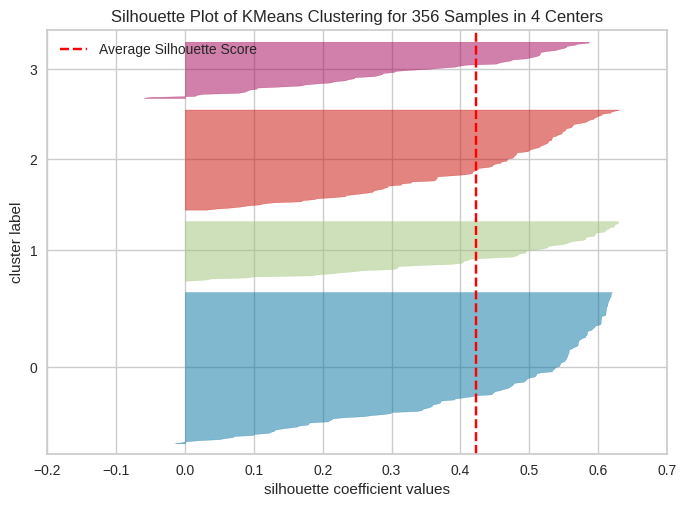

In [53]:
plot_model(mdl_kmeans_all, plot = 'silhouette')

In [56]:
plot_model(mdl_kmeans_all, plot = 'distribution')

In [58]:
df_kmeans_all = assign_model(mdl_kmeans_all)
df_kmeans_all

title_pt                              title_en  \
0                         Besouro Azul                       1. Besouro Azul   
1                               Barbie                             2. Barbie   
2                          Oppenheimer                        3. Oppenheimer   
3    As Tartarugas Ninja: Caos Mutante  4. As Tartarugas Ninja: Caos Mutante   
4                    Ruim Pra Cachorro                  5. Ruim Pra Cachorro   
..                                 ...                                   ...   
353                            Dunkirk                               Dunkirk   
354               Guardiões da Galáxia                  Guardiões da Galáxia   
355                            Titanic                               Titanic   
275                                NaN                                   NaN   
290                                NaN                                   NaN   

       year  rating      genre  \
0    2023.0     6.8       Ação   
1    2023.0     7.4   Aventura   
2    2023.0     8.6  Biografia   
3    2023.0     7.5   Animação   
4    2023.0     6.4   Animação   
..      ...     ...        ...   
353  2017.0     7.8       Ação   
354  2014.0     8.0       Ação   
355  1997.0     7.9      Drama   
275     NaN     NaN        NaN   
290     NaN     NaN        NaN   

                                               sinopse  word_count  \
0    jaime reyes, um adolescente de origem mexicana...        24.0   
1    viver na terra da barbie é ser um ser perfeito...        29.0   
2    a história do cientista americano j. robert op...        17.0   
3    os irmãos tartaruga trabalham para conquistar ...        19.0   
4    um cachorro abandonado se une a outros vira-la...        15.0   
..                                                 ...         ...   
353  soldados aliados da bélgica, do império britân...        25.0   
354  um grupo de criminosos intergalácticos deve se...        20.0   
355  uma aristocrata de dezessete anos se apaixona ...        20.0   
275                                                NaN         NaN   
290                                                NaN         NaN   

                                  sinopse_no_stopwords    0    1  ...  144  \
0    jaime reyes, adolescente origem mexicana encon...  0.0  0.0  ...  0.0   
1    viver terra barbie perfeito lugar perfeito. me...  0.0  0.0  ...  0.0   
2    história cientista americano j. robert oppenhe...  0.0  0.0  ...  0.0   
3    irmãos tartaruga trabalham conquistar amor cid...  0.0  0.0  ...  0.0   
4    cachorro abandonado une outros vira-latas ving...  0.0  0.0  ...  0.0   
..                                                 ...  ...  ...  ...  ...   
353  soldados aliados bélgica, império britânico fr...  0.0  0.0  ...  0.0   
354  grupo criminosos intergalácticos deve unir imp...  NaN  NaN  ...  NaN   
355  aristocrata dezessete anos apaixona artista ge...  NaN  NaN  ...  NaN   
275                                                NaN  0.0  0.0  ...  0.0   
290                                                NaN  0.0  0.0  ...  0.0   

          145  146  147  148  149       150  151  152    Cluster  
0    0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  Cluster 0  
1    0.000000  0.0  0.0  0.0  0.0  0.750457  0.0  0.0  Cluster 0  
2    0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  Cluster 0  
3    0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  Cluster 0  
4    0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  Cluster 0  
..        ...  ...  ...  ...  ...       ...  ...  ...        ...  
353  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  Cluster 0  
354       NaN  NaN  NaN  NaN  NaN       NaN  NaN  NaN  Cluster 0  
355       NaN  NaN  NaN  NaN  NaN       NaN  NaN  NaN  Cluster 2  
275  0.301640  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  Cluster 2  
290  0.267453  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  Cluster 2  

[356 rows x 162 columns]

Cluster 0


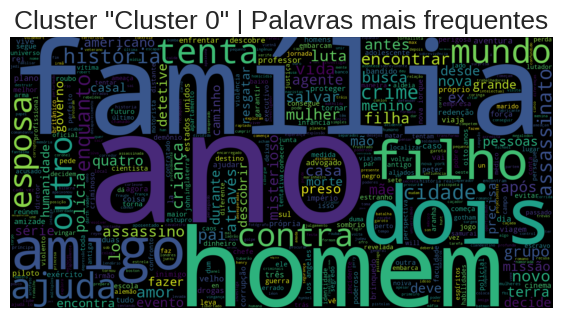

Cluster 2


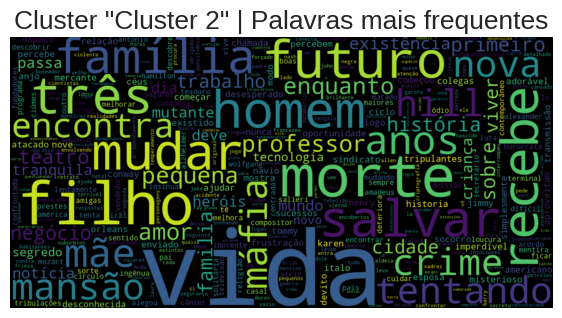

Cluster 3


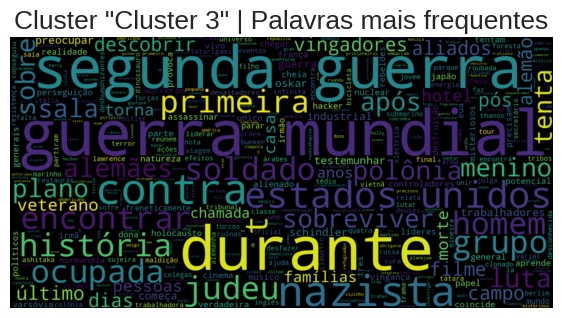

Cluster 1


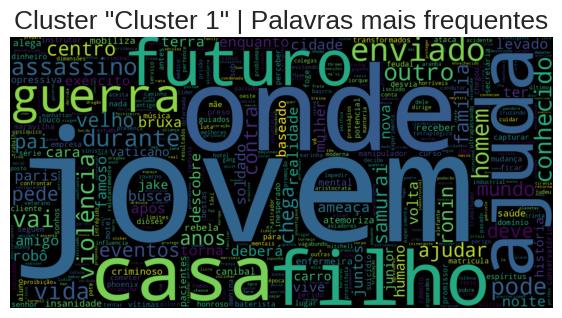

In [60]:
list_clusters = df_kmeans_all.Cluster.unique().tolist()
for c in list_clusters:
  print(c)
  if str(c) != "nan":
    word_cloud_cluster(c)